In [1]:
#QUENTIN_GROSHENS_2017#

In [4]:
import numpy as np

In [5]:
import pandas as pd

In [65]:
%matplotlib inline

In [4]:
#first_exercice: counting lines#

In [5]:
def number_lines(filename,N_chunk=10000):
    chunks=pd.read_csv(filename,sep='^',chunksize=N_chunk) #cutting file in chuncks to stay in memory
    n_lines=0
    for chunk in chunks:
        n_lines=n_lines+chunk.shape[0]
    return n_lines

In [6]:
number_lines("searches.csv")

20390198

In [7]:
number_lines("bookings.csv")

10000010

In [8]:
#second_exercice: top arrival airports#

In [18]:
#test with 10 bookings#

In [19]:
booking_df=pd.read_csv("bookings.csv",sep='^',nrows=10)

In [20]:
arr_df=booking_df[['arr_port','pax']]

In [21]:
arr_count=arr_df.groupby('arr_port').aggregate(sum)

In [22]:
arr_count.sort_values(by='pax',ascending=False )

,pax
arr_port,
SIN,6
CLT,2
LGA,2
SVO,2
LHR,-1


In [23]:
#test with 2 small chunk#

In [24]:
chunks=pd.read_csv("bookings.csv",sep='^',chunksize=10,nrows=20) #cutting file in chuncks to stay in memory


In [26]:
arr_count=pd.DataFrame()

In [27]:
for chunk in chunks:
    local_arr_count=chunk[['arr_port','pax']]
    local_arr_count=local_arr_count.dropna(axis=0, how='any')
    local_arr_count=local_arr_count.groupby('arr_port').aggregate(sum)
    arr_count=arr_count.add(local_arr_count,fill_value=0).astype(int)


In [28]:
arr_count

,pax
arr_port,
CLT,2
LGA,2
LHR,-1
SIN,4
SVO,2
TUS,1


In [29]:
#with the real data#

In [30]:
chunks=pd.read_csv("bookings.csv",sep='^',chunksize=10000) #cutting file in chuncks to stay in memory


In [31]:
arr_count=pd.DataFrame()#initialize count

In [32]:
for chunk in chunks:
    local_arr_count=chunk[['arr_port','pax']]
    local_arr_count=local_arr_count.dropna(axis=0, how='any')#drop rows with Nans
    local_arr_count=local_arr_count.groupby('arr_port').aggregate(sum)#sum by arrival airport
    arr_count=arr_count.add(local_arr_count,fill_value=0).astype(int)

In [33]:
arr_count.sort_values(by='pax',ascending=False )[:10]

,pax
arr_port,
LHR,88809
MCO,70930
LAX,70530
LAS,69630
JFK,66270
CDG,64490
BKK,59460
MIA,58150
SFO,58000


In [2]:
#preparation test for exercice 3#

In [60]:
search_df=pd.read_csv("searches.csv",sep='^',nrows=100000)

In [70]:
def date2month(date):
    #input string as a date eg: 'yyyy-mm-dd'
    #output string as a month eg: 'March'
    months_string=['January','February','March','April','May','June','July','August','September','October','November','December']
    month=int(date.split('-')[1])-1 #january=0 ect#
    return months_string[month]

In [71]:
date_df=search_df[search_df['Destination']== "AGP"]['Date'].apply(date2month)

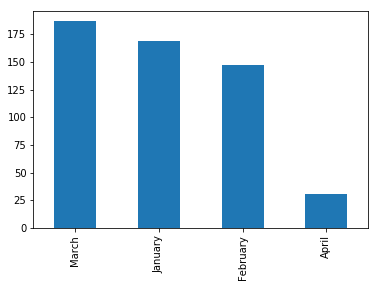

In [72]:
date_df.value_counts().plot(kind='bar')